In [1]:
'''
Author: invokred
Filename: advancedAnalysis
Description: Charting the pickup and dropoff locations on the map of New York
'''

#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats
from sklearn import cluster
from sklearn import decomposition

#customizing matplotlib
import matplotlib
matplotlib.style.use('seaborn-dark')
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['figure.figsize'] = (10, 10)

In [2]:
def preprocess(data):
    '''
    Removing latitude, longitude, time outliers from data set
    '''
    
    #create datasets of entire latitudes and longitudes
    allLat = np.array(list(data['pickup_latitude']) + list(data['dropoff_latitude']))
    allLong = np.array(list(data['pickup_longitude']) + list(data['dropoff_longitude']))
    
    #create limits for removing outliers in time, longitude, latitude
    lat_limit = [np.percentile(allLat, 0.3), np.percentile(allLat, 99.7)]
    long_limit = [np.percentile(allLong, 0.3), np.percentile(allLong, 99.7)]
    time_limit = [np.percentile(data['trip_duration'], 0.4), np.percentile(data['trip_duration'], 99.7)]
    
    #removing outliers
    data = data[(data['pickup_longitude'] >= long_limit[0]) & (data['pickup_longitude'] <= long_limit[1])]
    data = data[(data['dropoff_longitude'] >= long_limit[0]) & (data['dropoff_longitude'] <= long_limit[1])]
    data = data[(data['pickup_latitude'] >= lat_limit[0]) & (data['pickup_latitude'] <= lat_limit[1])]
    data = data[(data['dropoff_latitude'] >= lat_limit[0]) & (data['dropoff_latitude'] <= lat_limit[1])]
    data = data[(data['trip_duration'] >= time_limit[0]) & (data['trip_duration'] <= time_limit[1])]
    
    data = data.reset_index(drop = True)
    
    #getting kilometre range from centre point in data for input streamlining in machine learning 
    mean_lat = np.percentile(allLat, 50)
    mean_long = np.percentile(allLong, 50)
    
    latMultiplier = 111 #source https://www.thoughtco.com/degree-of-latitude-and-longitude-distance-4070616
    longMultiplier = np.cos(mean_lat * np.pi / 180) * latMultiplier
    
    data['source_latitude [km]'] = latMultiplier * (data['pickup_latitude'] - mean_lat)
    data['source_longitude [km]'] = longMultiplier * (data['pickup_longitude'] - mean_long)
    data['destination_latitude [km]'] = latMultiplier * (data['dropoff_latitude'] - mean_lat)
    data['destination_longitude [km]'] = longMultiplier * (data['dropoff_longitude'] - mean_long)
    
    #converting time from seconds to minutes for reduction in degrees of freedom
    data['trip_duration [min]'] = data['trip_duration'] / 60
    
    #recreating datasets of entire latitudes and longitudes in terms of difference of kilometers from the central points
    allLat = np.array(list(data['source_latitude [km]']) + list(data['destination_latitude [km]']))
    allLong = np.array(list(data['source_longitude [km]']) + list(data['destination_longitude [km]']))
    
    return data, allLat, allLong

In [3]:
def PlotHist(data, lat_arr, long_arr):
    '''
    Plot histograms of Time, Latitude, Longitude
    '''
    
    fig, axesArray = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 4))
    
    axesArray[0].hist(data['trip_duration [min]'], bins = 80)
    axesArray[0].set_xlabel('Trip Duration [min]')
    axesArray[0].set_ylabel('Counts')
    
    axesArray[1].hist(lat_arr, bins = 80)
    axesArray[1].set_xlabel('Latitude [km from central point (mean)]')
    
    axesArray[2].hist(long_arr, bins = 80)
    axesArray[2].set_xlabel('Longitude [km from central point (mean)]')
    
    plt.savefig('Figures/time-lat-long-distribution.png')

In [4]:
def PlotDistTime(data):
    '''
    Create a scatterplot between the distance in between source and destination and the time required to cover it
    '''
    
    data['euclidean distance'] = np.sqrt((data['source_latitude [km]'] - data['destination_latitude [km]']) ** 2 +
                                        (data['source_longitude [km]'] - data['destination_longitude [km]']) ** 2)
    data['log_time'] = np.log1p(data['trip_duration [min]'])
    
    fig, axesArray = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 4))
    
    axesArray[0].scatter(data['euclidean distance'], data['trip_duration [min]'], c = 'r', alpha = 0.01, marker = '.', s = 5)
    axesArray[0].set_xlabel('Euclidean Distance [km]')
    axesArray[0].set_ylabel('Time [min]')
    axesArray[0].set_xlim(data['euclidean distance'].min(), data['euclidean distance'].max())
    axesArray[0].set_ylim(data['trip_duration [min]'].min(), data['trip_duration [min]'].max())
    axesArray[0].set_title('Euclidean Distance v/s Time')
    
    axesArray[1].scatter(data['euclidean distance'], data['log_time'], c = 'r', alpha = 0.01, marker = '.', s = 5)
    axesArray[1].set_xlabel('Euclidean Distance [km]')
    axesArray[1].set_ylabel('Log of Time [min]')
    axesArray[1].set_xlim(data['euclidean distance'].min(), data['euclidean distance'].max())
    axesArray[1].set_ylim(data['log_time'].min(), data['log_time'].max())
    axesArray[1].set_title('Euclidean Distance v/s Log of Time')
    
    plt.savefig('Figures/travel-time-distance-scatterplot.png')

In [5]:
def PlotSpatialChart(allLat, allLong, latRange, longRange, imageSize):
    '''
    Plot the spatial density of latitudes and longitudes used
    '''

    allLatIndex = imageSize[0] - (imageSize[0] * (allLat - latRange[0]) / (latRange[1] - latRange[0])).astype(int)
        #the format for allLatIndex and allLongIndex is different as
        #2D arrays have ascending feature from left to right and top to bottom
        #but in GPS coordinates its from left to right and bottom to top [from equator to poles]
        #thus to complete the flipping of the image vertically subtraction from imageSize[0] has taken place
    allLongIndex = (imageSize[1] * (allLong - longRange[0]) / (longRange[1] - longRange[0])).astype(int)
    
    locationDensityMatrix = np.zeros(imageSize)
    for lat, long in zip(allLatIndex, allLongIndex):
        locationDensityMatrix[lat, long] += 1
        
    plt.figure(figsize = (10, 10))
    plt.axis('off')
    plt.imshow(np.log1p(locationDensityMatrix), cmap = 'hot')
    
    plt.savefig('Figures/spatial-density.png')
    
    return locationDensityMatrix

In [6]:
def PlotTripCluster(data, numCluster):
    '''
    Cluster 1.4 million trips into numCluster clusters and check its variation over time
    '''
    
    tripAttributes = np.array(data.iloc[:, 11:16])

    meanAttributes = tripAttributes.mean(axis = 0)
    stdAttributes = tripAttributes.std(axis = 0)
    #normalization
    tripAttributes = stats.zscore(tripAttributes, axis = 0)
    
    TripKmeansModel = cluster.MiniBatchKMeans(n_clusters = numClusters, batch_size = 120000, n_init = 100, random_state = 1)
    clusterInds = TripKmeansModel.fit_predict(tripAttributes)
    
    clusterTotalCounts, _ = np.histogram(clusterInds, bins = numClusters)
    sortedClusterInds = np.flipud(np.argsort(clusterTotalCounts))
    
    plt.figure(figsize = (12, 4))
    plt.title('Cluster histogram of all trips')
    plt.bar(range(1, numClusters + 1), clusterTotalCounts[sortedClusterInds])
    plt.xlabel('Cluster index (sorted by cluster frequency)')
    plt.ylabel('Frequency [counts]')
    plt.xlim(0, numClusters + 1)
    
    plt.savefig('Figures/cluster-histogram-distribution.png')

    return meanAttributes, stdAttributes, TripKmeansModel

In [7]:
def Convert2ImageCoordinates(allLat, allLong, lat_range, long_range, imageSize):
    '''
    Function to convert data to image coordinates
    '''
    
    allLatIndex = imageSize[0] - (imageSize[0] * (allLat - lat_range[0]) / (lat_range[1] - lat_range[0])).astype(int)
    allLongIndex = (imageSize[1] * (allLong - long_range[0]) / (long_range[1] - long_range[0])).astype(int)
    
    return allLatIndex, allLongIndex

In [8]:
def PlotTrips(meanAttributes, stdAttributes, numClusters, lat_range, long_range, imageSize, locationDensityMatrix, TripKmeansModel):
    '''
    Plot typtical trips in map with arrows and data
    '''
    
    testTrips = TripKmeansModel.cluster_centers_ * np.tile(stdAttributes, (numClusters, 1)) + np.tile(meanAttributes, (numClusters, 1))
    source_coordinates = testTrips[:, :2]
    destination_coordinates = testTrips[:, 2:4]
    
    source_image_coordinates = Convert2ImageCoordinates(source_coordinates[:, 0], source_coordinates[:, 1], lat_range, long_range, imageSize)
    destination_image_coordinates = Convert2ImageCoordinates(destination_coordinates[:, 0], destination_coordinates[:, 1], lat_range, long_range, imageSize)
    
    plt.figure(figsize = (12, 12))
    plt.imshow(np.log1p(locationDensityMatrix), cmap='hot')
    plt.axis('off')
    plt.grid(b = None)
    plt.scatter(source_image_coordinates[1], source_image_coordinates[0], c = 'm', s = 200, alpha = 0.8)
    plt.scatter(destination_image_coordinates[1], destination_image_coordinates[0], c = 'g', s = 200, alpha = 0.8)
    
    for i in range(len(source_image_coordinates[0])):
                   plt.arrow(source_image_coordinates[1][i], source_image_coordinates[0][i],
                            destination_image_coordinates[1][i]-source_image_coordinates[1][i], 
                            destination_image_coordinates[0][i]-source_image_coordinates[0][i],
                            edgecolor='c', facecolor='c',
                            width=0.8,
                            alpha=0.4,
                            head_width=10.0,
                            head_length=10.0,
                            length_includes_head=True)
    
    plt.savefig('Figures/cluster-centre-trip.png')

In [9]:
#read dataframe
trainDB = pd.read_csv(filepath_or_buffer = 'train.csv', delimiter = ',', engine = 'c', parse_dates = [2, 3], low_memory = True)

In [10]:
#preprocess the DataFrame
trainDB, allLat, allLong = preprocess(trainDB)

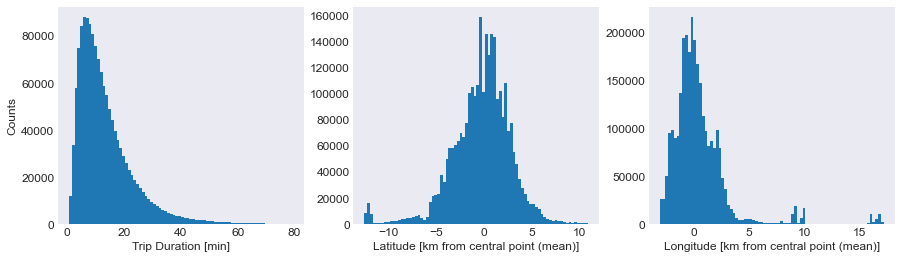

In [11]:
#Plot the histograms of Time, Latitude, Longitude
PlotHist(trainDB, allLat, allLong)

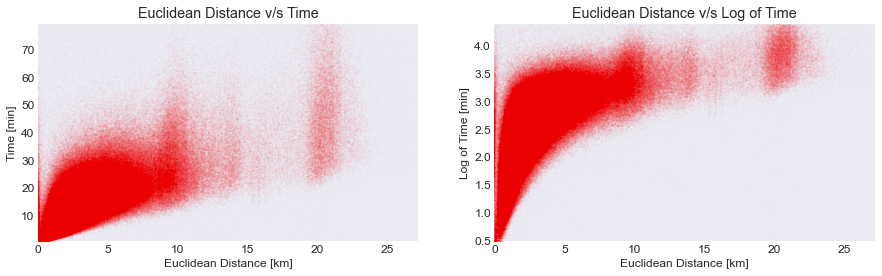

In [12]:
#Chart scatterplot between Euclidean Distance b/w source and distination and the time taken
PlotDistTime(trainDB)

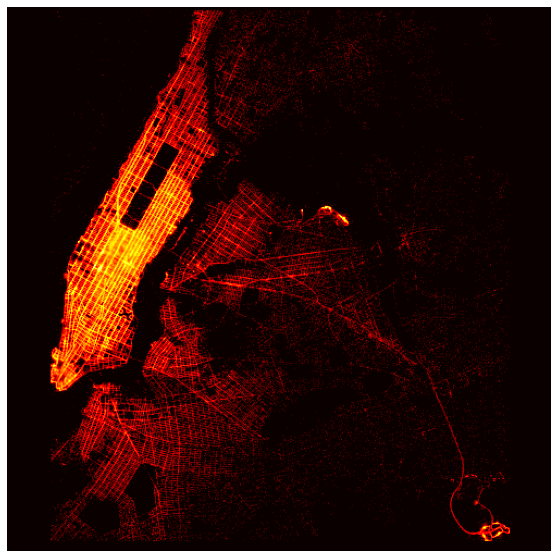

In [13]:
#Chart spatial density plot of Pickup & Dropoff Locations
imageSize = (500, 500)
latRange = [-13, 11] #calculated from the observed histograms for latitude variation
longRange = [-5, 19] #calculated from the observed histograms for longitude variation
locationDensityMatrix = PlotSpatialChart(allLat, allLong, latRange, longRange, imageSize)    

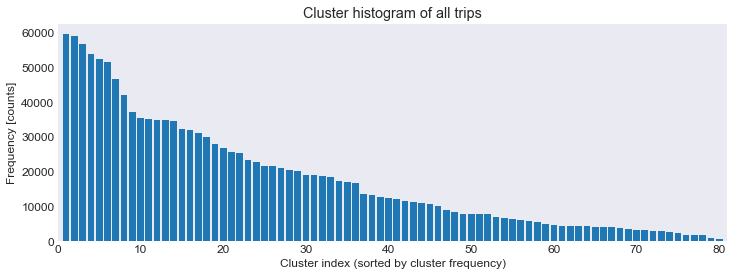

In [14]:
#Plot trip clusters and their distribution
numClusters = 80
meanTripAttr, stdTripAttr, TripKmeansModel = PlotTripCluster(trainDB, numClusters)

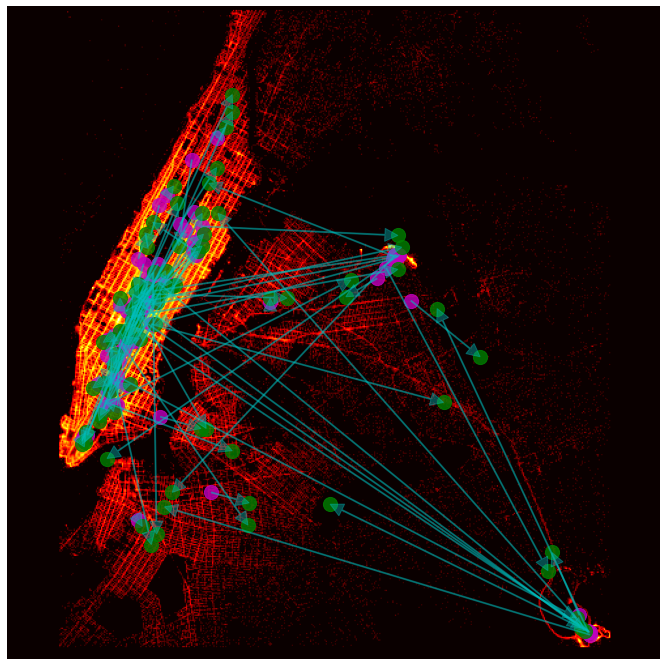

In [15]:
# Show the typical trips on the map
PlotTrips(meanTripAttr, stdTripAttr, numClusters, latRange, longRange, imageSize, locationDensityMatrix, TripKmeansModel)